# Peter Kim, OCPython Meetup - August 1, 2017
PeopleSpace, Irvine, CA

## Text Classification with Scikit-Learn
Lending Club Dataset
>Original Source: https://www.lendingclub.com/info/download-data.action
><br>Kaggle Discussion: https://www.kaggle.com/wendykan/lending-club-loan-data

## Inspiration Reference:
When Words Sweat: Identifying Signals for Loan Default in the Text of Loan Applications
>Netzer, Oded and Lemaire, Alain and Herzenstein, Michal, When Words Sweat: Identifying Signals for Loan Default in the Text of Loan Applications (November 6, 2016). Columbia Business School Research Paper No. 16-83. Available at SSRN: https://ssrn.com/abstract=2865327.  

## Background References on Text Classification and Python/Scikit-Learn.
>PyCon 2016 Tutorial from Data School, “Machine Learning with Text in scikit-learn (PyCon 2016),” by Kevin Markham on May 28, 2016. 
* YouTube Lecture Available at: https://www.youtube.com/watch?v=ZiKMIuYidY0  
* Github Available at: https://github.com/justmarkham/pycon-2016-tutorial
>
><br> scikit-learn, “Working with Text Data”.  Available at: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
<br>
><br> Kaggle tutorial, “Bag of Words Meets Bags of Popcorn.”  December 9 2014 – June 30, 2015.  Available at: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
<br>
><br> scikit-learn, “Feature Extraction (Customizing the Vectorizer Class)”.  Available at: http://scikit-learn.org/stable/modules/feature_extraction.html
>
><br> Andreas Müller and Sarah Guido, "Introduction to Machine Learning with Python," O'Reilly Media, October 2016.  Available at: http://shop.oreilly.com/product/0636920030515.do
>
><br> Sebastian Raschka, "Python Machine Learning," Packt Publishing; 1 edition (September 23, 2015).  Available at: https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning

## Note: This Jupyter notebook uses Python 3 (other one uses Python 2).

In [2]:
# Python libraries
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [3]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

In [5]:
# Create Pandas Dataframe with Lending Club data from 2007-2011.
# The "2007-2011.csv" file has been cleaned-up from original "LoanStats3a.csv".  
df_lendingclub = pd.read_csv("2007-2011.csv")

# How many rows and columns?
df_lendingclub.shape    

(39786, 120)

In [6]:
# Make sure it loaded correctly.
df_lendingclub.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# What are the columns?  
print(list(df_lendingclub.columns))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_

In [8]:
# Examine first record, first 20 columns.
df_lendingclub.iloc[0, 0:20]

loan_amnt                                                           5000
funded_amnt                                                         5000
funded_amnt_inv                                                     4975
term                                                           36 months
int_rate                                                          10.65%
installment                                                       162.87
grade                                                                  B
sub_grade                                                             B2
emp_title                                                            NaN
emp_length                                                     10+ years
home_ownership                                                      RENT
annual_inc                                                         24000
verification_status                                             Verified
issue_d                                            

In [9]:
# Examine first record, 'desc'.
df_lendingclub['desc'][0]

'  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>'

In [10]:
# Examine first record, 'loan_status'.
df_lendingclub['loan_status'][0]

'Fully Paid'

## Column Descriptions From Lending Club Data Dictionary:
>'desc': Loan description provided by the borrower
<br>
<br>'loan_status': Current status of the loan

In [11]:
# Create new dataframe with 2 columns: 'desc' and 'loan_status'
df_text = df_lendingclub[['desc', 'loan_status']].copy()

# How many rows and columns?
print(df_text.shape)

# See if it loaded correctly.
df_text.head()

(39786, 2)


,desc,loan_status
0,Borrower added on 12/22/11 > I need to upgra...,Fully Paid
1,Borrower added on 12/22/11 > I plan to use t...,Charged Off
2,NaN,Fully Paid
3,Borrower added on 12/21/11 > to pay for prop...,Fully Paid
4,Borrower added on 12/21/11 > I plan on combi...,Fully Paid


## Loan Status of Total Loans

In [12]:
# Total number of loans
print("Total number of loans: ", df_text.shape[0])

# How many are Fully Paid vs. Charged off?
loan_status = df_text['loan_status'].value_counts()
print("\nTotal loans by loan status: ")
print(loan_status)

# What % of loans are Fully Paid?
print("\n% of total loans by loan status: ")
print(loan_status/df_text.shape[0])

Total number of loans:  39786

Total loans by loan status: 
Fully Paid     34116
Charged Off     5670
Name: loan_status, dtype: int64

% of total loans by loan status: 
Fully Paid     0.857488
Charged Off    0.142512
Name: loan_status, dtype: float64


## Loans  with Blank Descriptions by Loan Status

In [13]:
# How many 'desc' fields are blank?
blank_desc = df_text['desc'].isnull().sum()
print("Number of loans with blank descriptions: ", blank_desc)
print("% of loans with blank descriptions: ", blank_desc/df_text.shape[0])

# Of the loans with blank descriptions, what is loan status?
blank_loan_status = df_text[df_text['desc'].isnull()]['loan_status'].value_counts()
print("\nLoans with blank descriptions by loan status: ")
print(blank_loan_status)

# What % of loans with blank descriptions are Fully Paid?
print("\n% of loans with blank descriptions by loan status: ")
print(blank_loan_status/blank_desc)

Number of loans with blank descriptions:  12966
% of loans with blank descriptions:  0.325893530388

Loans with blank descriptions by loan status: 
Fully Paid     11147
Charged Off     1819
Name: loan_status, dtype: int64

% of loans with blank descriptions by loan status: 
Fully Paid     0.85971
Charged Off    0.14029
Name: loan_status, dtype: float64


## Only Loans with Descriptions

In [14]:
# Only include loans with descriptions, use dropna() method.
df_text_desc = df_text.dropna()
df_text_desc.head()

,desc,loan_status
0,Borrower added on 12/22/11 > I need to upgra...,Fully Paid
1,Borrower added on 12/22/11 > I plan to use t...,Charged Off
3,Borrower added on 12/21/11 > to pay for prop...,Fully Paid
4,Borrower added on 12/21/11 > I plan on combi...,Fully Paid
6,Borrower added on 12/18/11 > I am planning o...,Fully Paid


In [15]:
# How many loans have a description?
print("Number of loans with a description: ", df_text_desc.shape[0])

# Loans with description by loan status?
print("\nLoans with descriptions by loan status: ")
loan_status_desc = df_text_desc['loan_status'].value_counts()
print(loan_status_desc)

# What % of loans with descriptions are Fully Paid vs. Charged Off?
print("\n% of loans with descriptions by loan status: ")
print(loan_status_desc/df_text_desc.shape[0])

Number of loans with a description:  26820

Loans with descriptions by loan status: 
Fully Paid     22969
Charged Off     3851
Name: loan_status, dtype: int64

% of loans with descriptions by loan status: 
Fully Paid     0.856413
Charged Off    0.143587
Name: loan_status, dtype: float64


## Very Important to Balance the Classes
Particularly for high-dimensional, highly-sparse datasets
> Blagus, Rok and Lusa, Lara, “SMOTE for high-dimensional class-imbalanced data,” BMC Bioinformatics, March 22, 2013.  Available at: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106
>
><br>Blagus, Rok and Lusa, Lara, “Class prediction for high-dimensional class-imbalanced data,” BMC Bioinformatics, October 20, 2010.  Available at: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-523
>
><br>Alexander Yun-chung Liu, “The Effect of Oversampling and Undersampling on Classifying Imbalanced Text Datasets,” Thesis for M.S.E., The University of Texas at Austin, August 2004.  Available at: https://pdfs.semanticscholar.org/cade/435c88610820f073a0fb61b73dff8f006760.pdf
>
><br>Nick Becker Github page, “The Right Way to Oversample in Predictive Modeling,” December 23, 2016.  Available at: https://beckernick.github.io/oversampling-modeling/


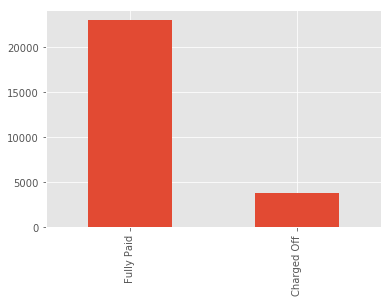

In [16]:
# Bar chart showing different size of "Fully Paid" vs. "Charged Off"
df_text_desc['loan_status'].value_counts().plot(kind='bar')

In [17]:
'''
In order to balance the classes, under-sample the majority class.
Over-sampling the majority class can be done with SMOTE (Synthetic Minority Over-Sampling), 
but does not yield good results for high-dimensional, high-sparse datasets.  
'''

# Save Fully Paid (majority class) as separate dataframe.
fully_paid = df_text_desc['loan_status'] == 'Fully Paid'
df_fully_paid = df_text_desc[fully_paid]

# Run pandas.sample method to use same number of samples as minority class.  
num_samples = loan_status_desc[1]    # number of loans "Charged Off" (e.g. 3851)
df_fp_undersample = df_fully_paid.sample(num_samples, random_state=1)  
df_fp_undersample.shape

(3851, 2)

In [18]:
# Save minority class as separate dataframe.
charged_off = df_text_desc['loan_status'] == 'Charged Off'
df_charged_off = df_text_desc[charged_off]
df_charged_off.shape

(3851, 2)

In [19]:
# Concatenate the "Fully Paid" (under-sampled) and "Charged Off" into one dataframe
bal_frames = [df_fp_undersample, df_charged_off]
df_balanced = pd.concat(bal_frames)
df_balanced.shape

(7702, 2)

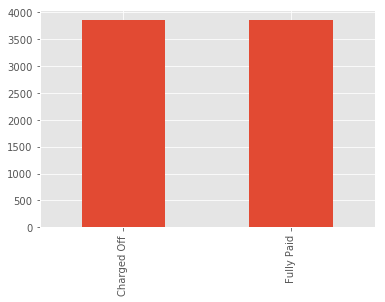

In [20]:
# Bar chart showing different size of "Fully Paid" vs. "Charged Off" (Balanced)
df_balanced['loan_status'].value_counts().plot(kind='bar')

## Train/Test Split

In [21]:
# Split the Content and Classes into train and test sets (20%).
# To ensure that it splits it according to same class ratio, use "stratify" parameter.  
X_train, X_test, y_train, y_test = train_test_split(df_balanced['desc'], df_balanced['loan_status'], 
                                                    random_state=1, test_size=0.2, stratify=df_balanced['loan_status'])

# Print the size of each train and test datasets
print('X training size: ', X_train.shape)
print('y training size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X training size:  (6161,)
y training size:  (6161,)
X test size:  (1541,)
y test size:  (1541,)


In [22]:
# X_train is the loan descriptions from 'desc' field (80% of total)
X_train[0:5]

12060      Borrower added on 07/04/11 > I plan to use t...
33900     575633 added on 11/18/09 > I plan on using th...
29767      Borrower added on 05/23/10 > This loan if fu...
39462    I hope to use the money to consolidate two cre...
37935    Thank you for taking the time to consider my a...
Name: desc, dtype: object

In [23]:
# y_train is the class data, a.k.a. "label data" or "target classes" (80% of total)
y_train[0:5]

12060    Charged Off
33900     Fully Paid
29767     Fully Paid
39462    Charged Off
37935    Charged Off
Name: loan_status, dtype: object

In [24]:
# The test_train_split output retains the data type as a panda series.  
# Later we will run a list comprehension so this data, changing data type.
# Either data type should work fine.
type(X_train)

pandas.core.series.Series

In [25]:
# The test data represents 20% of the total.  X_test is loan descriptions, y_test is class data.

In [26]:
# Check the y_test value_counts to verify confusion matrix
y_test.value_counts()

Fully Paid     771
Charged Off    770
Name: loan_status, dtype: int64

## Option 1: Vectorize Text into Document-Term-Matrix (no pre-processing)
* Leave text unprocessed, no lemmatization

In [28]:
# Instantiate a vectorizer for document-term-matrix
vect = CountVectorizer(max_features=1000)

# Fit the vectorizer object to the X_train text
X_train_vect = vect.fit(X_train, y_train)

# Transform the training text into a document-term-matrix
X_train_dtm = X_train_vect.transform(X_train)

print("Size of training dtm: ", X_train_dtm.shape)

Size of training dtm:  (6161, 1000)


In [29]:
# Transform the test text into a document-term-matrix (input fed into models)
X_test_dtm = X_train_vect.transform(X_test)

print("Size of test dtm: ", X_test_dtm.shape)

Size of test dtm:  (1541, 1000)


## Option 2a: Vectorize Text into Document-Term-Matrix (with pre-processing)

## Pre-processing text  
Using techniques from Kaggle tutorial  and Scikit-Learn Tutorial.  (See references at the top).
1. Create process_chars function
1. List comprehension applying function to data.
1. Create a LemmaTokenizer class
1. Instantiate CountVectorizer object with LemmaTokenizer

In [52]:
# Step 1: Create process_chars function.

# Use stopwords from NLTK, but also add individual letters.
stop_nltk = stopwords.words("english")
stop_nltk_plus = stop_nltk + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',
                         u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',
                         u'u',u'v',u'w',u'x',u'y',u'z']
# In Python, searching a set is much faster than searching
# a list, so convert the stop words to a set.  
# Use this "steps" set in the below function.  
stops = set(stop_nltk_plus)
    
# function to process documents
def process_chars(input_text):
    # Remove non-letters, and make lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", input_text)
        
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()    
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [53]:
# Step 2: List comprehension applying function to data.

# Process the text of X_train.  Keep same name for simplicity.
X_train = [process_chars(text_file) for text_file in X_train]

# Process the text of X_train.  Keep same name for simplicity.
X_test = [process_chars(text_file) for text_file in X_test]

In [54]:
# Step 3: Create a LemmaTokenizer class.  
# Based on Scikit-Learn "Feature Extraction" page.

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [55]:
# Step 4: Instantiate CountVectorizer object with LemmaTokenizer.
# Based on Scikit-Learn "Feature Extraction" page.

# instantiate CountVectorizer object, with LemmaTokenizer()
count_vect_lemma = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 2), max_features=400, 
                                   max_df=0.90, stop_words='english')   

In [56]:
%%time

# Size of training dtm:  (6161, 1000)
# Wall time: 20.2 s


# Fit the vectorizer object to the X_train text data
X_train_vect = count_vect_lemma.fit(X_train)

# Transform the training text into a document-term-matrix
X_train_dtm = X_train_vect.transform(X_train)

print("Size of training dtm: ", X_train_dtm.shape)

Size of training dtm:  (6161, 400)
Wall time: 11.9 s


In [57]:
%%time

# Size of test dtm:  (1541, 1000)
# Wall time: 2.12 s


# Transform the test text into a document-term-matrix (input fed into models)
X_test_dtm = X_train_vect.transform(X_test)

print("Size of test dtm: ", X_test_dtm.shape)

Size of test dtm:  (1541, 400)
Wall time: 1.04 s


## Option 2b: In addition to CountVectorizer, use TfidfTransformer
Let's try 3 different options:
1. TfidfTransformer(use_idf=True)
1. TfidfTransformer(use_idf=False)
1. Don't use TfidfTransformer at all

In [69]:
# Instantiate a TfidfTransformer object, fit the X_train_dtm data, save as object.
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_dtm)

# Transform the X_train_dtm data to the TfidfTransformer.  
# Could name is something else, but keeping same name for simplicity.
X_train_dtm = tf_transformer.transform(X_train_dtm)

# What is the shape of the document-term-matrix?  (Should be same.)
X_train_dtm.shape

(6161, 400)

## Option 2c: In addition to CountVectorizer, use TruncatedSVD
TruncatedSVD used for dimensionality reduction, particular with sparse matrices (e.g. text matrices).

When TruncatedSVD is used in conjunction with CountVectorizer and Tfidf, it is known as Latent Semantic Analysis (LSA).

Scikit-Learn Documentation on TruncatedSVD
> http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
<br>
><br>http://scikit-learn.org/stable/modules/decomposition.html
<br>
><br>http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [ ]:
svd = TruncatedSVD()

normalizer = Normalizer(copy=True)

lsa = make_pipeline(svd, normalizer)

X_train_dtm = lsa.fit_transform(X_train_dtm)

X_test_dtm = lsa.transform(X_test_dtm)

## Option 3: Vectorize Text Using Hashing Vectorizer
Usually HashingVectorizer is used to vectorize text documents that do not fit in memory.  But maybe it can be used as a dimensionality reduction technique, and improve prediction accuracy.
<br>
<br>Scikit-Learn Documentation on HashingVectorizer:
>http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer
<br>
><br>http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [81]:
# Perform an IDF normalization on the output of HashingVectorizer
hasher = HashingVectorizer(n_features=400,tokenizer=LemmaTokenizer(),
                           stop_words='english', non_negative=True,
                           norm=None, binary=False)

# Vectorizer uses pipeline to combine hasher and TfidfTransformer
vectorizer = make_pipeline(hasher, TfidfTransformer(use_idf=False))

# Create X_train_dtm
X_train_dtm = vectorizer.fit_transform(X_train)

# Create X_test_dtm
X_test_dtm = vectorizer.transform(X_test)

## Option 4: Text Classification with Word2Vec
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [1]:
# An idea to explore in the future.

## Text Classification Example Without GridSearchCV
* In practice, the GridSearchCV class accomplishes same result, while tuning combinations of model parameters.
* But to make it simpler to follow the workflow, here is an example of text classification step-by-step.

In [82]:
# Step 1: Instatiate a classifier object.
rf_clf = RandomForestClassifier()

# Step 2: "Fit" training data onto model, both data and labels.
# The machine is "learning" how the training words match the label data (or "classes").  
rf_clf.fit(X_train_dtm, y_train)

# Step 3: Predict test data using model, only data (not labels)
# Store results as predictions on test data ... next we will compare with real labels.  
rf_test_predictions = rf_clf.predict(X_test_dtm)

In [83]:
print("Random Forest Classifier: ")

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, rf_test_predictions))

# print the confusion matrix
print("\nConfusion Matrix: ")
print("(rows are actual, columns are predictions)")
print(metrics.confusion_matrix(y_test, rf_test_predictions, labels=["Charged Off", "Fully Paid"]))

# print the Classification Report
print("\nClassification Report: ")
print(metrics.classification_report(y_test, rf_test_predictions,target_names=["Charged Off", "Fully Paid"]))

Random Forest Classifier: 
0.523036988968

Confusion Matrix: 
(rows are actual, columns are predictions)
[[486 284]
 [451 320]]

Classification Report: 
             precision    recall  f1-score   support

Charged Off       0.52      0.63      0.57       770
 Fully Paid       0.53      0.42      0.47       771

avg / total       0.52      0.52      0.52      1541



# Classification Technique #1: Random Forest Classifier

In [84]:
%%time

# 0.546664502516
# bootstrap: True
# class_weight: 'balanced'
# n_estimators: 50
# Wall time: 57.5 s

# Use GridSearchCV to tune model parameters

# parameters 
parameters_rf = {'n_estimators': (10, 50, 100),                 # default 10
                 'bootstrap': (True, False),                    # default true
                  'class_weight': ('balanced', None)}           # default None

# instantiate a classifier object
rf = RandomForestClassifier(random_state=42)

# instantiate a GridSearchCV object
gs_rf = GridSearchCV(rf, parameters_rf, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_rf = gs_rf.fit(X_train_dtm, y_train)

print(gs_rf.best_score_)

for param_name in sorted(parameters_rf.keys()):
    print("%s: %r" % (param_name, gs_rf.best_params_[param_name]))

0.538711248174
bootstrap: True
class_weight: 'balanced'
n_estimators: 100
Wall time: 1min 4s


In [85]:
print("Random Forest Classifier: ")

# predict classification
gs_rf_test_predictions = gs_rf.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_rf_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_rf_test_predictions))

print(metrics.classification_report(y_test, gs_rf_test_predictions,target_names=["Charged Off", "Fully Paid"]))

Random Forest Classifier: 
0.543153796236
[[430 340]
 [364 407]]
             precision    recall  f1-score   support

Charged Off       0.54      0.56      0.55       770
 Fully Paid       0.54      0.53      0.54       771

avg / total       0.54      0.54      0.54      1541



# Classification Technique #2: Multinomial Naive Bayes

In [86]:
%%time

# Use GridSearchCV to tune model parameters

# Grid Search for MultinomialNB
# Accuracy:  0.561434832008
# alpha:  1.0
# fit_prior:  True
# Wall time: 6.71 s
    
# parameters for MultinomialNB
parameters_mnb = {'alpha': (0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
                 'fit_prior': (True, False)}    # default is True, use uniform if False

# instantiate a MultinomialNB object
mnb = MultinomialNB()

# instantiate a GridSearchCV object
gs_mnb = GridSearchCV(mnb, parameters_mnb, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

print("Grid Search for MultinomialNB")
print("Accuracy: ", gs_mnb.best_score_)
print("alpha: ", gs_mnb.best_params_['alpha'])
print("fit_prior: ", gs_mnb.best_params_['fit_prior'])
# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

Grid Search for MultinomialNB
Accuracy:  0.541470540497
alpha:  0.1
fit_prior:  False
Wall time: 6.31 s


In [87]:
print("Multinomial Naive Bayes: ")

# predict classification
gs_mnb_test_predictions = gs_mnb.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_mnb_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_mnb_test_predictions))

# print classification report
print(metrics.classification_report(y_test, gs_mnb_test_predictions))

Multinomial Naive Bayes: 
0.550940947437
[[394 376]
 [316 455]]
             precision    recall  f1-score   support

Charged Off       0.55      0.51      0.53       770
 Fully Paid       0.55      0.59      0.57       771

avg / total       0.55      0.55      0.55      1541



In [88]:
# Verify classes against the y_test data
print("Compare Target Class Label Counts to Classification Report")
print("0: Ham, 1: Spam\n")
print(y_test.value_counts(ascending=True))

Compare Target Class Label Counts to Classification Report
0: Ham, 1: Spam

Charged Off    770
Fully Paid     771
Name: loan_status, dtype: int64


# Classification Technique #3: Support Vector Machines

In [89]:
%%time

# Use GridSearchCV to tune model parameters

# 0.949720670391
# alpha: 0.01
# class_weight: 'balanced'
# penalty: 'elasticnet'
# Wall time: 23 s

# parameters for SVM
parameters_svm = {'penalty': (None, 'l1', 'l2', 'elasticnet'),  # default is 'l2'
                  'alpha': (0.0001, 0.01, 1.0),                 # default 0.0001
                  'class_weight': ('balanced', None)}           # default None

# instantiate a SVM object
svm = SGDClassifier(loss='hinge', random_state=42)

# instantiate a GridSearchCV object
gs_svm = GridSearchCV(svm, parameters_svm, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_svm = gs_svm.fit(X_train_dtm, y_train)

print(gs_svm.best_score_)

for param_name in sorted(parameters_svm.keys()):
    print("%s: %r" % (param_name, gs_svm.best_params_[param_name]))

0.537899691609
alpha: 0.01
class_weight: None
penalty: None
Wall time: 6.79 s


In [90]:
print("Support Vector Machines: ")

# predict classification
gs_svm_test_predictions = gs_svm.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_svm_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_svm_test_predictions))

print(metrics.classification_report(y_test, gs_svm_test_predictions))

Support Vector Machines: 
0.550940947437
[[412 358]
 [334 437]]
             precision    recall  f1-score   support

Charged Off       0.55      0.54      0.54       770
 Fully Paid       0.55      0.57      0.56       771

avg / total       0.55      0.55      0.55      1541



# Classification Technique #4: Logistic Regression

In [91]:
%%time

# Use GridSearchCV to tune model parameters

# 0.95530726257
# C: 1.0
# class_weight: None
# penalty: 'l2'
# Wall time: 5.55 s

# parameters 
parameters_lr = {'penalty': ('l1', 'l2'),               # default is 'l2'
                  'C': (0.01, 1.0, 10.0, 100.0),            # default 1.0
                  'class_weight': ('balanced', None)}                         # default None

# instantiate a LogisticRegression object
lr = LogisticRegression(random_state=42)

# instantiate a GridSearchCV object
gs_lr = GridSearchCV(lr, parameters_lr, n_jobs=-1)

# fit the GridSearchCV object to the training data
gs_lr = gs_lr.fit(X_train_dtm, y_train)

print(gs_lr.best_score_)

for param_name in sorted(parameters_lr.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))

0.540009738679
C: 0.01
class_weight: None
penalty: 'l2'
Wall time: 7.76 s


In [92]:
print("Logistic Regression: ")

# predict classification
gs_lr_test_predictions = gs_lr.predict(X_test_dtm)

# print accuracy of class predictions
print(metrics.accuracy_score(y_test, gs_lr_test_predictions))

# print the confusion matrix
print(metrics.confusion_matrix(y_test, gs_lr_test_predictions))

print(metrics.classification_report(y_test, gs_lr_test_predictions))

Logistic Regression: 
0.565217391304
[[432 338]
 [332 439]]
             precision    recall  f1-score   support

Charged Off       0.57      0.56      0.56       770
 Fully Paid       0.56      0.57      0.57       771

avg / total       0.57      0.57      0.57      1541



# Comparison of Models (w/o Pre-Processing, with GridSearch)
Option 1: Vectorize Text into Document-Term-Matrix (no pre-processing)

(Precision, Recall, F1-Score for the "Charged Off" Class Only)

| Model                    | Accuracy   | Precision    | Recall    | F1-Score    |          
|--------------------------|------------|--------------|-----------|-------------|          
| Random Forest            | 0.5665     | 0.56         | 0.59      | 0.58        |          
| Multinomial Naive Bayes  | 0.5840     | 0.59         | 0.56      | 0.57        |          
| Support Vector Machines  | 0.5827     | 0.58         | 0.60      | 0.59        |          
| Logistic Regression      | 0.5840     | 0.59         | 0.57      | 0.58        |          


# Comparison of Models (with Pre-Processing, with GridSearch)
Option 2a: Vectorize Text into Document-Term-Matrix (with pre-processing)

(Precision, Recall, F1-Score for the "Charged Off" Class Only)

| Model                    | Accuracy   | Precision    | Recall    | F1-Score    |          
|--------------------------|------------|--------------|-----------|-------------|          
| Random Forest            | 0.5775     | 0.57         | 0.60      | 0.59        |          
| Multinomial Naive Bayes  | 0.5749     | 0.57         | 0.59      | 0.57        |          
| Support Vector Machines  | 0.5483     | 0.54         | 0.59      | 0.57        |          
| Logistic Regression      | 0.5737     | 0.57         | 0.59      | 0.58        |          


Option 2b: In addition to CountVectorizer, use TfidfTransformer(use_idf=True)

(Precision, Recall, F1-Score for the "Charged Off" Class Only)

| Model                    | Accuracy   | Precision    | Recall    | F1-Score    |          
|--------------------------|------------|--------------|-----------|-------------|          
| Random Forest            | 0.5042     | 0.50         | 0.49      | 0.50        |          
| Multinomial Naive Bayes  | 0.5749     | 0.57         | 0.59      | 0.57        |          
| Support Vector Machines  | 0.5483     | 0.54         | 0.59      | 0.57        |          
| Logistic Regression      | 0.5737     | 0.57         | 0.59      | 0.58        |   

Option 3: Vectorize Text Using Hashing Vectorizer

(Precision, Recall, F1-Score for the "Charged Off" Class Only)

| Model                    | Accuracy   | Precision    | Recall    | F1-Score    |          
|--------------------------|------------|--------------|-----------|-------------|          
| Random Forest            | 0.5432     | 0.54         | 0.56      | 0.55        |          
| Multinomial Naive Bayes  | 0.5509     | 0.55         | 0.51      | 0.53        |          
| Support Vector Machines  | 0.5509     | 0.55         | 0.54      | 0.54        |          
| Logistic Regression      | 0.5652     | 0.57         | 0.56      | 0.56        |   